
# Cueing Single Subject Analysis


## Setup




In [1]:
# Some standard pythonic imports
import os,numpy as np#,sys,glob,pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# MNE functions
from mne import Epochs,find_events#, concatenate_raws
from mne.time_frequency import tfr_morlet

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data,plot_conditions
from eegnb.datasets import fetch_dataset

## Load Data

We will use the eeg-expy visual cueing example dataset




In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    
cueing_data_path = os.path.join(eegnb_data_path, 'visual-cueing', 'kylemathlab_dev')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(cueing_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-cueing', site='kylemathlab_dev');


sub = 302
sess = 1
raw = load_data(sub,1, # subject, session
                experiment='visual-cueing',site='kylemathlab_dev',device_name='muse2016',
                data_dir = eegnb_data_path)
                
raw.append(
      load_data(sub,2, # subject, session
                experiment='visual-cueing', site='kylemathlab_dev', device_name='muse2016',
                data_dir = eegnb_data_path))

Downloading...
From (original): https://drive.google.com/uc?id=1ABOVJ9S0BeJOsqdGFnexaTFZ-ZcsIXfQ
From (redirected): https://drive.google.com/uc?id=1ABOVJ9S0BeJOsqdGFnexaTFZ-ZcsIXfQ&confirm=t&uuid=deccb319-830b-495d-8537-cb10a1294e59
To: C:\Users\pavit\.eegnb\data\downloaded_data.zip
100%|██████████| 102M/102M [00:28<00:00, 3.60MB/s] 




Loading these files: 

C:\Users\pavit\.eegnb\data\visual-cueing\kylemathlab_dev\muse2016\subject0302\session001\subject302_session1_recording_2018-11-20-17.10.25.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.


Loading these files: 

C:\Users\pavit\.eegnb\data\visual-cueing\kylemathlab_dev\muse2016\subject0302\session002\subject302_session2_recording_2018-11-20-17.18.04.csv

C:\Users\pavit\.eegnb\data\visual-cueing\kylemathlab_dev\muse2016\subject0302\session002\subject302_session2_recording_2018-11-20-17.31.03.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
[

## Visualize the power spectrum

Plot raw data




Using matplotlib as 2D backend.


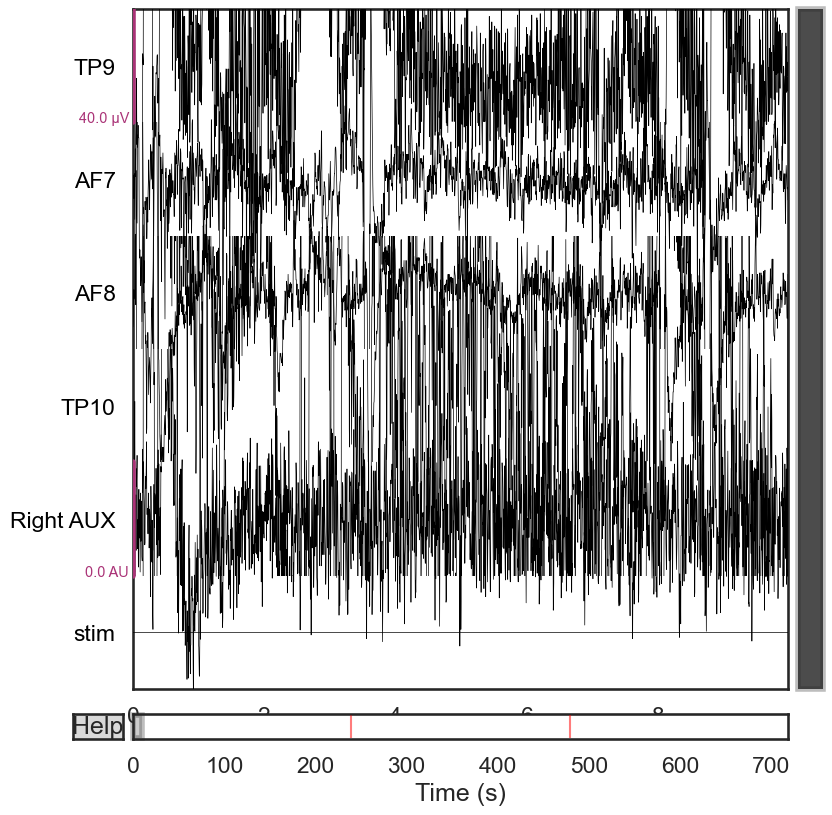

In [3]:
raw.plot();

## Power Spectral Density

One way to analyze the SSVEP is to plot the power spectral density, or PSD. SSVEPs should appear as peaks in power for certain frequencies. We expect clear peaks in the spectral domain at the stimulation frequencies of 30 and 20 Hz.




In [4]:
raw.compute_psd().plot();

# Should see the electrical noise at 60 Hz, and maybe a peak at the red and blue channels between 7-14 Hz (Alpha)

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


## Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.




In [5]:
raw.filter(1,30, method='iir');
raw.compute_psd(fmin=1, fmax=30).plot();

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


## Epoching

Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.




In [6]:
raw.filter(1,30, method='iir')
events = find_events(raw)
event_id = {'LeftCue': 1, 'RightCue': 2}

rej_thresh_uV = 150
rej_thresh = rej_thresh_uV*1e-6

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-1, tmax=2, baseline=(-1, 0), 
                reject={'eeg':rej_thresh}, preload=True,
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

conditions = OrderedDict()
#conditions['LeftCue'] = [1]
#conditions['RightCue'] = [2]
conditions['LeftCue'] = ['LeftCue']
conditions['RightCue'] = ['RightCue']
diffwave = ('LeftCue', 'RightCue')

fig, ax = plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=diffwave, ylim=(-20,20))

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Finding events on: stim
213 events found on stim channel stim
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  95.77464788732395


## Spectrogram

We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time




NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: mean)
No baseline correction applied


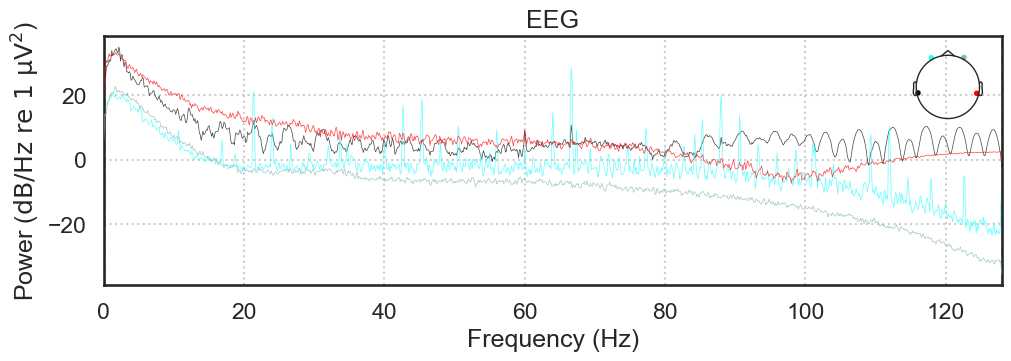

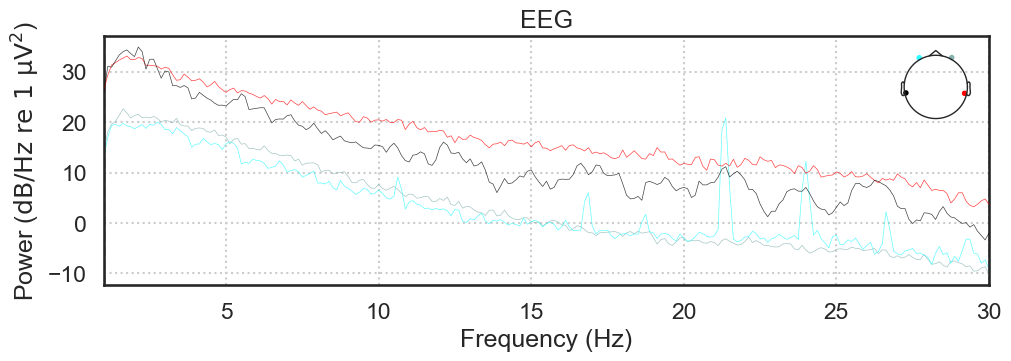

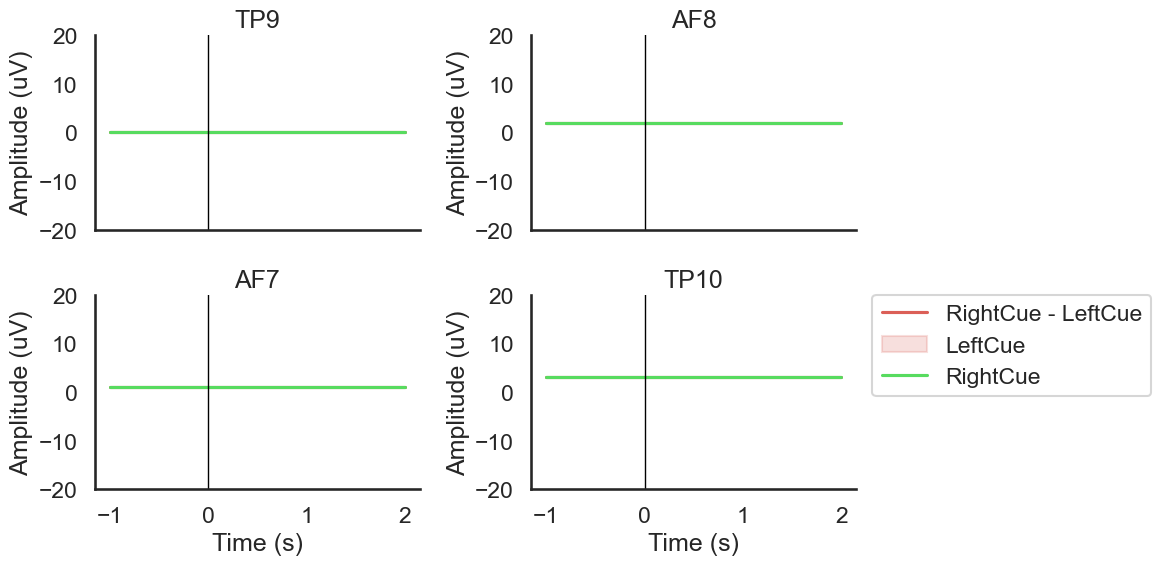

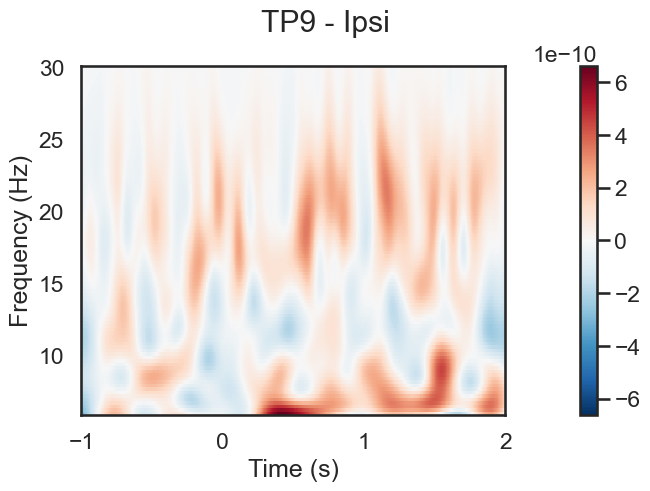

No baseline correction applied


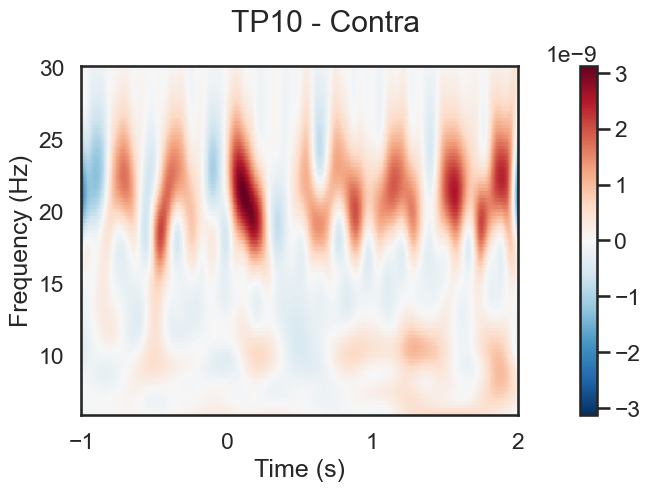

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: mean)
No baseline correction applied


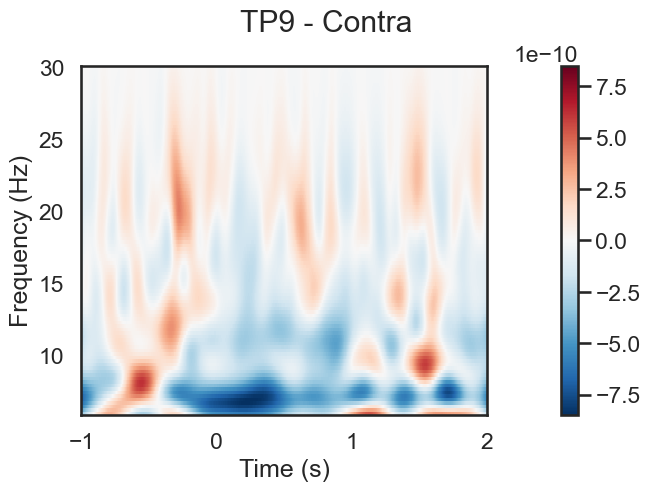

No baseline correction applied


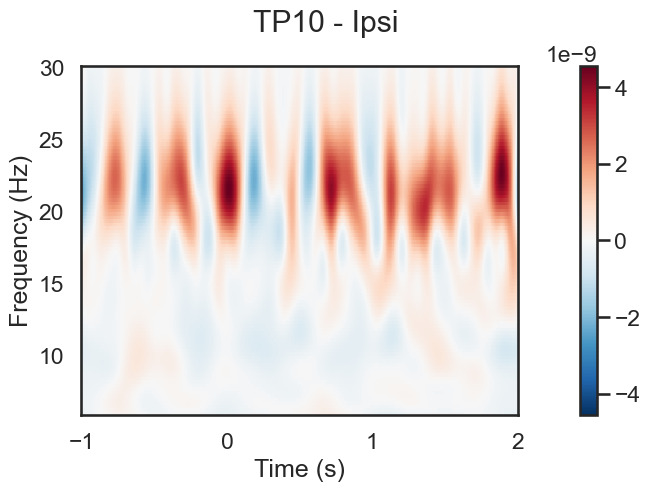

In [7]:
frequencies =  np.linspace(6, 30, 100, endpoint=True)

wave_cycles = 6

# Compute morlet wavelet

# Left Cue
tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=True)
tfr = tfr.apply_baseline((-1,-.5),mode='mean')
tfr.plot(picks=[0], mode='logratio', 
         title='TP9 - Ipsi');
tfr.plot(picks=[1], mode='logratio', 
         title='TP10 - Contra');
power_Ipsi_TP9 = tfr.data[0,:,:]
power_Contra_TP10 = tfr.data[1,:,:]

# Right Cue
tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=True)
tfr = tfr.apply_baseline((-1,-.5),mode='mean')
tfr.plot(picks=[0], mode='logratio', 
         title='TP9 - Contra');
tfr.plot(picks=[1], mode='logratio', 
         title='TP10 - Ipsi');
power_Contra_TP9 = tfr.data[0,:,:]
power_Ipsi_TP10 = tfr.data[1,:,:]

## Now we compute and plot the differences

time frequency window for analysis



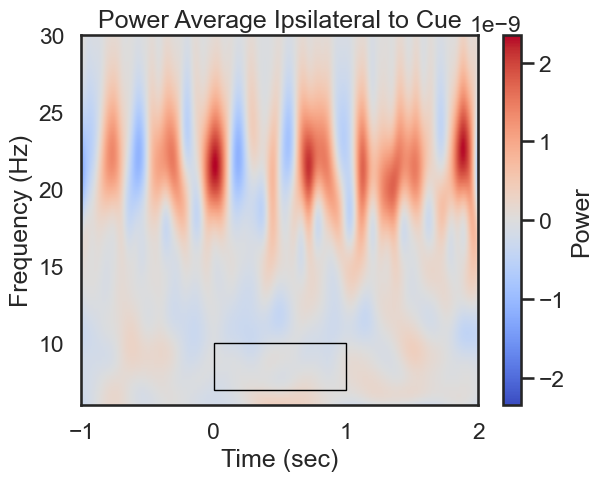

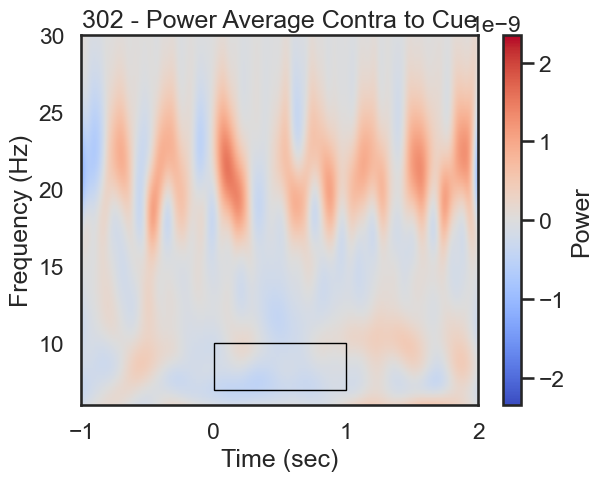

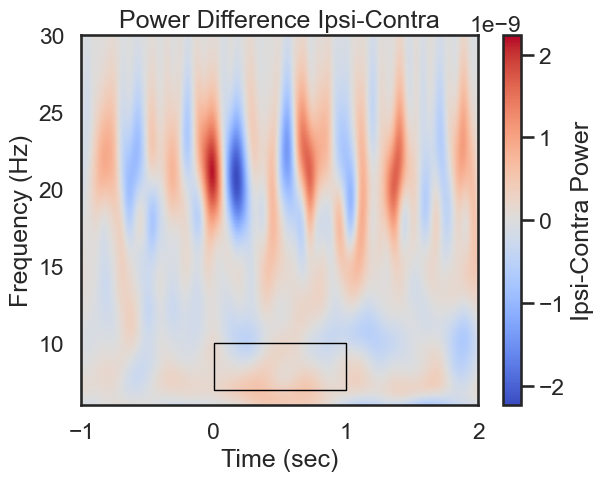

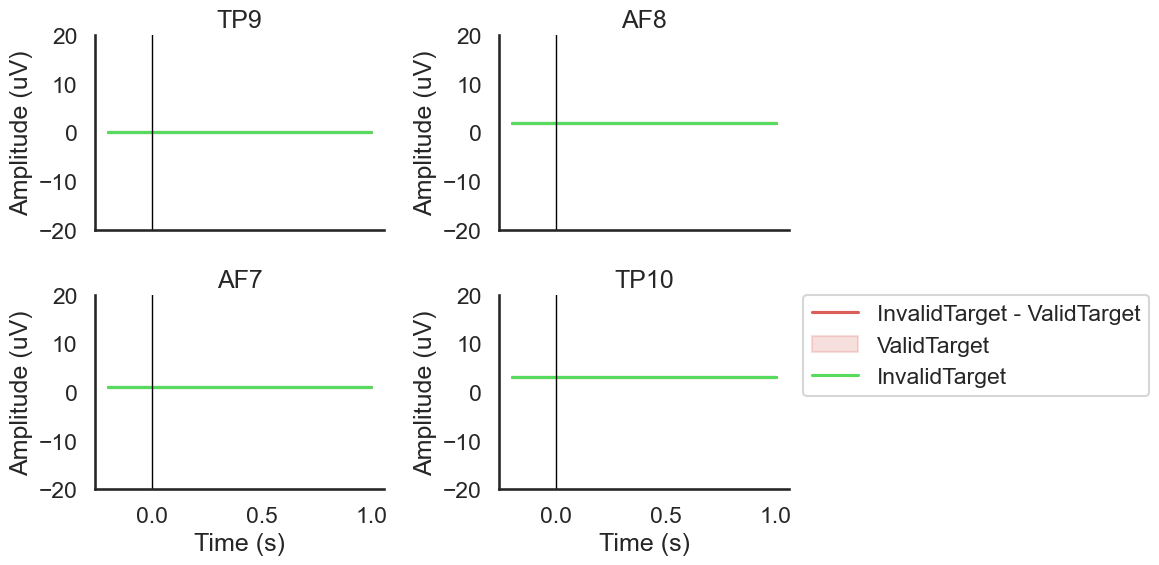

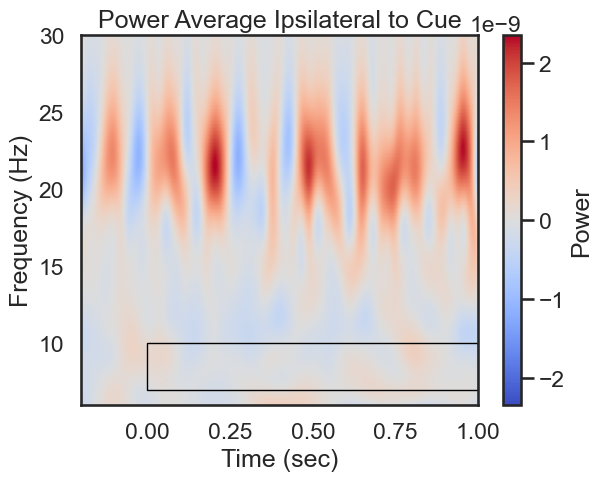

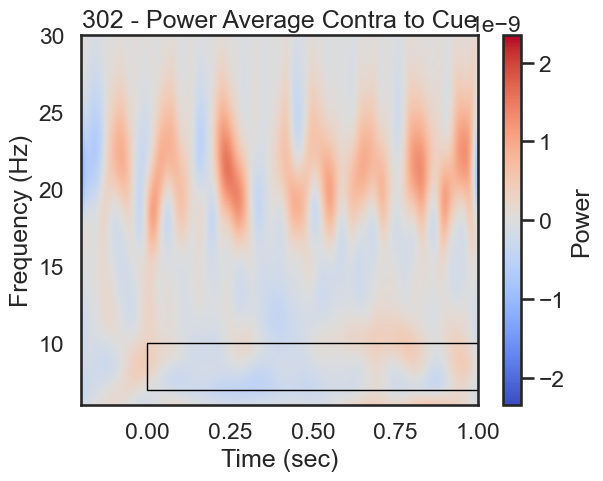

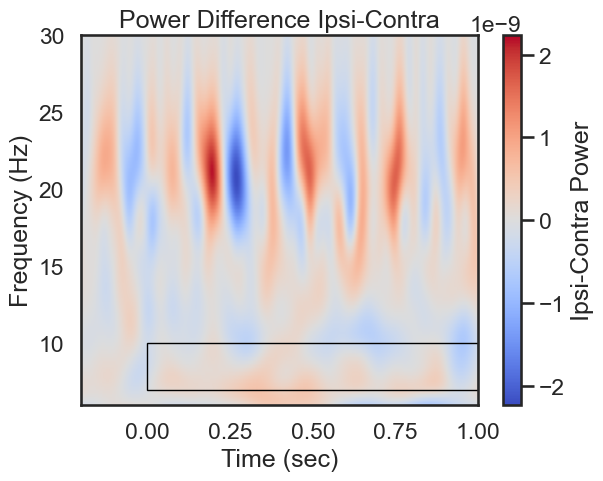

In [10]:
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

# Plot Differences
times = epochs.times
power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;

# find max to make color range
plot_max = np.max([np.max(np.abs(power_Avg_Ipsi)), np.max(np.abs(power_Avg_Contra))])
plot_diff_max = np.max(np.abs(power_Avg_Diff))

# Ipsi
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Ipsi,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Average Ipsilateral to Cue')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#TP10
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Contra,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title(str(sub) + ' - Power Average Contra to Cue')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#difference between conditions
fig, ax = plt.subplots(1)
im = plt.imshow(power_Avg_Diff,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Difference Ipsi-Contra')
cb = fig.colorbar(im)
cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


# We expect greater alpha power ipsilateral to the cue direction (positive values) from 0 to 1.5 seconds

## Target Epoching

Next, we will chunk (epoch) the data into segments representing the data .200ms before to 1000ms after each target, we will reject every epoch where the amplitude of the signal exceeded ? uV, which should most eye blinks.




In [9]:
events = find_events(raw)
event_id = {'InvalidTarget_Left': 11, 'InvalidTarget_Right': 12,
           'ValidTarget_Left': 21,'ValidTarget_Right': 11}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-.2, tmax=1, baseline=(-.2, 0), 
                reject={'eeg':.0001}, preload=True,
                verbose=False, picks=[0, 1, 2, 3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

conditions = OrderedDict()
conditions['ValidTarget'] = ['ValidTarget_Left', 'ValidTarget_Right']
conditions['InvalidTarget'] = ['InvalidTarget_Left', 'InvalidTarget_Right']
diffwave = ('ValidTarget', 'InvalidTarget')

fig, ax = plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=diffwave, ylim=(-20,20))

Finding events on: stim
213 events found on stim channel stim
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  89.67136150234741
